<figure style="float:right">
    <img
    src="./data/callat_logo.png"
    width="150"
    alt="CalLat logo"
    /img>
</figure>

# Jupyter notebook for CalLat gA project 

## Import libraries

In [1]:
from __future__ import print_function

import pandas as pd
pd.options.display.max_rows = 16
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib as mpl
import lsqfit
import gvar as gv
import callat_ga_lib as xlib
import sys
print("python version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy  version:", np.__version__)
print("scipy  version:", sp.__version__)
print("mpl    version:", mpl.__version__)
print("lsqfit version:", lsqfit.__version__)
print("gvar   version:", gv.__version__)

python version: 2.7.14 (default, Sep 25 2017, 09:53:22) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]
pandas version: 0.20.1
numpy  version: 1.12.1
scipy  version: 0.19.0
mpl    version: 2.0.2
lsqfit version: 9.1.3
gvar   version: 8.2.3


## Define analysis parameters
* `switches['ensembles']` | list of strings
    * select the ensembles that are used to perform the extrapolation
    * the three rows correspond to the 0.15, 0.12, and 0.09 fm ensembles that are available
* `switches['ansatz']` | dictionary
    * define the fit ansatz for the extrapolation
    * `['type']` | string: chooses between a Taylor expansion or Baryon Xpt
        * Taylor expansion only includes even powers of ε<sub>π</sub>
    * `['truncation']` | integer: is an integer n corresponding to the order of ε<sub>π</sub><sup>n</sup>
    * `['FV']` | boolean: True turns on NLO FV corrections for both Baryon Xpt and Taylor
    * `['xsb']` | boolean: True turns on am<sub>π</sub> term for Baryon Xpt
    * `['alpha']` | boolean: True turns on α<sub>s</sub>a<sup>2</sup> for Baryon Xpt

In [2]:
switches = dict()
# Ensembles used in extrapolation
switches['ensembles'] = [
    'a15m400','a12m400','a09m400',
    'a15m350','a12m350','a09m350',
    'a15m310','a12m310','a09m310',
    'a15m220','a12m220','a09m220','a12m220S','a12m220L',
    'a15m130','a12m130'
    ]
switches['x_shift'] = {
    'a15m400':0,    'a12m400':0,  'a09m400':0,
    'a15m350':0,    'a12m350':0,  'a09m350':0,
    'a15m310':0,    'a12m310':0,  'a09m310':0,
    'a15m220':-.002,'a12m220':.00,'a09m220':.004,'a12m220S':-.003,'a12m220L':.002,
    'a15m130':-.001,'a12m130':.001
    }

switches['ansatz'] = dict()
### Type of fit: 'xpt_N', 'taylor_N', 'linear_N', 'constant_N', 'xpt-full_4', 'xpt-doublelog_4', 'xpt-delta_N'
switches['ansatz']['type'] = ['xpt_3','xpt_4','taylor_2','taylor_4','linear_2','linear_4']
#switches['ansatz']['type'] = ['xpt_4']
switches['ansatz']['FV'] = True # True turns on NLO FV correction
switches['ansatz']['FVn'] = 3 # FV(epi^n) where n in [2,3]
switches['ansatz']['xsb'] = False # True turns on O(a) discretization
switches['ansatz']['alpha'] = False # True turns on O(alpha_s a^2) discretization
### Save figs to local directory?
switches['save_figs'] = True
### plot tools 
switches['plot'] = dict()
switches['plot']['chiral'] = False
switches['plot']['continuum'] = False
switches['plot']['FV'] = False
switches['plot']['model_avg_histogram'] = True
### For the switches below to work
### the corresponding plot above must be True
switches['plot']['model_avg_chiral'] = True
switches['plot']['model_avg_cont'] = True
switches['plot']['model_avg_fv'] = True
### LEC report
switches['lecs'] = True #print LECs
switches['lecs_full'] = False #True print ALL LECs, False, print from lec list
### multiplicative factor for prior width of epsilon_delta
switches['eps_delta_sig'] = 0.05
switches['axial_sig'] = 0.23 # 0.23 the optimal width based upon NLO fits and Bayes factors
### inflation of prior widths
### multiplicative factor for NxLO LECs
p_lo = 1.
p_nlo = 1.
p_nnlo = 1.
p_nnloa = 1.
### prior width for epi**3 FV function
fv_3_width = 2.
### FV coefficient in Taylor expansion analyses
g0_fv = 1.2
g0_fv_width = 1.0 # loose width
#g0_fv_width = 0.3 # reasonable ChiPT width
#g0_fv_width = 0.1 # tight width
### remove estimated QED corrections from mpi and Fpi
switches['qed'] = False

## Define priors and PDG values
`gvar` datatype has the form `gv.gvar(mean, standard deviation)`

[gvar documentation](https://github.com/gplepage/gvar/blob/master/doc/gvar.pdf)

In [3]:
priors = dict()
# Xpt priors
priors['xpt'] = dict()
priors['xpt']['g0'] = gv.gvar(1.0, p_lo*50.0) # LO LEC
priors['xpt']['a1'] = gv.gvar(0.0, 1E-3) # DWF order a discretization
priors['xpt']['c2'] = gv.gvar(0.0, p_nlo*50.0) # NLO counterterm epi^2
priors['xpt']['c3'] = gv.gvar(0.0, p_nnlo*50.0) # NNLO LEC epi^3
priors['xpt']['a2'] = gv.gvar(0.0, p_nlo*50.0) # NLO a^2
priors['xpt']['s2'] = gv.gvar(0.0, 1.0) # NLO alpha_s a^2
priors['xpt']['a4'] = gv.gvar(0.0, p_nnloa*p_nnlo*1.0) # NNNLO a^4
priors['xpt']['b4'] = gv.gvar(0.0, p_nnlo*1.0) # NNNLO a^2 epi^2
priors['xpt']['c4'] = gv.gvar(0.0, p_nnlo*1.0) # NNNLO epi^4
priors['xpt']['gm4'] = gv.gvar(0.0, 50.0) # NNNLO log term
priors['xpt']['gnd0'] = gv.gvar(-6./5*1.2,switches['axial_sig']*6/5*1.2) # delta LECs
priors['xpt']['gdd0'] = gv.gvar(-9./5*1.2,switches['axial_sig']*9/5*1.2) # delta LECs
priors['xpt']['f3'] = gv.gvar(0.,fv_3_width) # epi^3 FV coefficient
# taylor priors
priors['taylor'] = dict()
priors['taylor']['g0'] = gv.gvar(g0_fv, p_nlo*g0_fv_width) # FV coefficient
priors['taylor']['c0'] = gv.gvar(1.0, p_lo*50.0) # constant
priors['taylor']['c2'] = gv.gvar(0.0, p_nlo*50.0) # epi^2
priors['taylor']['a2'] = gv.gvar(0.0, p_nlo*50.0) # a^2
priors['taylor']['c4'] = gv.gvar(0.0, p_nnlo*1.0) # epi^4
priors['taylor']['a4'] = gv.gvar(0.0, p_nnloa*p_nnlo*1.0) # a^4
priors['taylor']['b4'] = gv.gvar(0.0, p_nnlo*1.0) # a^2 epi^2
priors['taylor']['f3'] = gv.gvar(0.,fv_3_width) # epi^3 FV coefficient
# linear priors
priors['linear'] = dict()
priors['linear']['g0'] = gv.gvar(g0_fv, p_nlo*g0_fv_width) # FV coefficient
priors['linear']['c0'] = gv.gvar(1.0, p_lo*50.0) # constant
priors['linear']['c2'] = gv.gvar(0.0, p_nlo*50.0) # epi
priors['linear']['a2'] = gv.gvar(0.0, p_nlo*50.0) # a^2
priors['linear']['a4'] = gv.gvar(0.0, p_nnloa*p_nnlo*1.0) # a^4
priors['linear']['c4'] = gv.gvar(0.0, p_nnlo*1.0) # epi^2
priors['linear']['f3'] = gv.gvar(0.,fv_3_width) # epi^3 FV coefficient
# constant priors
priors['constant'] = dict()
priors['constant']['g0'] = gv.gvar(g0_fv, p_nlo*g0_fv_width) # FV coefficient
priors['constant']['c0'] = gv.gvar(1.0, p_lo*10.0) # constant
priors['constant']['a2'] = gv.gvar(0.0, p_nlo*10.0) # a^2
priors['constant']['a4'] = gv.gvar(0.0, p_nnloa*p_nnlo*1.0) # a^4
priors['constant']['f3'] = gv.gvar(0.,fv_3_width) # epi^3 FV coefficient


# Physical parameters from PDG
phys_params = dict()
# http://pdg.lbl.gov/2016/tables/rpp2016-tab-mesons-light.pdf
phys_params['mpi'] = gv.gvar(139.57018, 0.00035) # mpi +/- [MeV]
# http://pdg.lbl.gov/2016/reviews/rpp2016-rev-pseudoscalar-meson-decay-cons.pdf
phys_params['fpi'] = gv.gvar(130.2, 1.7) # fpi + ['MeV']
# Turn off QED?
if switches['qed']:
    phys_params['mpi'] = gv.gvar(134.9770, 0.0005) # mpi 0 [MeV]
    phys_params['fpi'] = gv.gvar(130.2, 1.7)/(1+0.5*gv.gvar(0.0169,.0015))
# http://pdg.lbl.gov/2017/listings/rpp2017-list-Delta-1232.pdf
phys_params['Delta'] = gv.gvar(293, 2) # Delta(1232) Breit Wigner Mass

## Import data
[pandas dataframe documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

In [4]:
# import correlator bootstraps
gadf = pd.read_csv('./data/github_ga_v2.csv')
gadf.groupby('ensemble').describe()[['ga','epi','mpil']]

ga                                          \
                               count      mean       std       min       25%   
ensemble                                                                       
l1648f211b580m013m065m838     5001.0  1.215922  0.011742  1.180243  1.207896   
l1648f211b580m0166m065m838    5001.0  1.195976  0.012855  1.131798  1.188054   
l1648f211b580m0217m065m838    5001.0  1.215268  0.005890  1.186484  1.211468   
l2448f211b580m0064m0640m828   5001.0  1.273958  0.014018  1.216328  1.264678   
l2464f211b600m00507m0507m628  5001.0  1.271018  0.027648  1.175531  1.252519   
l2464f211b600m0102m0509m635   5001.0  1.213870  0.012636  1.165909  1.205374   
l2464f211b600m0130m0509m635   5001.0  1.235816  0.013839  1.185734  1.226364   
l2464f211b600m0170m0509m635   5001.0  1.216168  0.009613  1.183379  1.209574   
l3248f211b580m00235m0647m831  5001.0  1.262219  0.072413  1.071303  1.213338   
l3264f211b600m00507m0507m628  5001.0  1.258742  0.014600  1.197767  1.248760   
l3264f211b630m00945m037m440   5001.0  1.227386  0.014756  1.176808  1.217545   
l3264f211b630m0124m037m440    5001.0  1.209714  0.007889  1.174845  1.204458   
l3296f211b630m0074m037m440    5001.0  1.236013  0.010839  1.203184  1.228802   
l4064f211b600m00507m0507m628  5001.0  1.251906  0.021038  1.172414  1.238134   
l4864f211b600m00184m0507m628  5001.0  1.289305  0.029890  1.180580  1.268853   
l4896f211b630m00363m0363m430  5001.0  1.252071  0.008538  1.209421  1.246589   

                                                               epi            \
                                   50%       75%       max   count      mean   
ensemble                                                                       
l1648f211b580m013m065m838     1.214899  1.222887  1.281075  5001.0  0.249570   
l1648f211b580m0166m065m838    1.197044  1.204830  1.234361  5001.0  0.274111   
l1648f211b580m0217m065m838    1.215434  1.219343  1.235284  5001.0  0.303739   
l2448f211b580m0064m0640m828   1.273961  1.283095  1.329689  5001.0  0.180843   
l2464f211b600m00507m0507m628  1.270476  1.289662  1.380602  5001.0  0.184187   
l2464f211b600m0102m0509m635   1.213805  1.222645  1.253815  5001.0  0.244855   
l2464f211b600m0130m0509m635   1.235015  1.243912  1.308450  5001.0  0.270633   
l2464f211b600m0170m0509m635   1.216208  1.222540  1.257217  5001.0  0.298413   
l3248f211b580m00235m0647m831  1.254129  1.300221  1.847861  5001.0  0.113400   
l3264f211b600m00507m0507m628  1.258865  1.268513  1.315906  5001.0  0.182205   
l3264f211b630m00945m037m440   1.227342  1.237122  1.287559  5001.0  0.269494   
l3264f211b630m0124m037m440    1.209716  1.215047  1.237058  5001.0  0.298178   
l3296f211b630m0074m037m440    1.235073  1.242075  1.359632  5001.0  0.246186   
l4064f211b600m00507m0507m628  1.251229  1.264230  1.339749  5001.0  0.181555   
l4864f211b600m00184m0507m628  1.288847  1.309447  1.394666  5001.0  0.113472   
l4896f211b630m00363m0363m430  1.251934  1.257544  1.288477  5001.0  0.181974   

                                ...                           mpil            \
                                ...          75%       max   count      mean   
ensemble                        ...                                            
l1648f211b580m013m065m838       ...     0.249802  0.251079  5001.0  3.777244   
l1648f211b580m0166m065m838      ...     0.274443  0.275956  5001.0  4.235926   
l1648f211b580m0217m065m838      ...     0.304102  0.305840  5001.0  4.845108   
l2448f211b580m0064m0640m828     ...     0.181045  0.181978  5001.0  3.967344   
l2464f211b600m00507m0507m628    ...     0.184557  0.187149  5001.0  3.252292   
l2464f211b600m0102m0509m635     ...     0.245199  0.246465  5001.0  4.528191   
l2464f211b600m0130m0509m635     ...     0.271084  0.273317  5001.0  5.135239   
l2464f211b600m0170m0509m635     ...     0.298757  0.300450  5001.0  5.842808   
l3248f211b580m00235m0647m831    ...     0.113904  0.116193  5001.0  3.226630   
l3264f211b600m00507m0507m628    

In [5]:
# import HISQ parameters
hqdf = pd.read_csv('./data/hisq_params.csv')
hqdf

,ensemble,aw0_mean,aw0_sdev,alfs,eps_delta
0,l1648f211b580m0217m065m838,0.8804,0.0003,0.58801,0.224774
1,l1648f211b580m0166m065m838,0.8804,0.0003,0.58801,0.232021
2,l1648f211b580m013m065m838,0.8804,0.0003,0.58801,0.236900
3,l2448f211b580m0064m0640m828,0.8804,0.0003,0.58801,0.245520
4,l3248f211b580m00235m0647m831,0.8804,0.0003,0.58801,0.252021
5,l2464f211b600m0170m0509m635,0.7036,0.0005,0.53796,0.219530
6,l2464f211b600m0130m0509m635,0.7036,0.0005,0.53796,0.226525
7,l2464f211b600m0102m0509m635,0.7036,0.0005,0.53796,0.232421
8,l2464f211b600m00507m0507m628,0.7036,0.0005,0.53796,0.243425
9,l3264f211b600m00507m0507m628,0.7036,0.0005,0.53796,0.243077


## Format data for analysis

In [6]:
data = xlib.format_data(switches, gadf, hqdf)

## Chiral-continuum fit
[lsqfit documentation](https://github.com/gplepage/lsqfit/blob/master/doc/lsqfit.pdf)

In [7]:
result = xlib.fit_data(switches, priors, data, phys_params)
lecs = {
    'xpt_2'      :['g0','c2'],
    'xpt_3'      :['g0','c2','c3'],
    'xpt_4'      :['g0','c2','c3','c4'],
    'xpt-full_4' :['g0','c2','c3','c4','gm4'],
    'xpt-delta_2':['g0','c2','gnd0','gdd0'],
    'xpt-delta_3':['g0','c2','c3','gnd0','gdd0'],
    'xpt-delta_4':['g0','c2','c3','c4','gnd0','gdd0'],
    'taylor_2'   :['c0','c2','g0'],
    'taylor_4'   :['c0','c2','c4','g0'],
    'linear_2'   :['c0','c2','g0'],
    'linear_4'   :['c0','c2','c4','g0'],
}
for a in switches['ansatz']['type']:
    #print(result[a]['fit']) #uncomment to print entire fit results
    print("\n%s physical point result:" %a, result[a]['phys']['result'])
    print('%s, %s, %s, %s' %(result[a]['phys']['result'].mean, result[a]['phys']['result'].sdev, result[a]['fit'].chi2/result[a]['fit'].dof, result[a]['fit'].logGBF))
    print(result[a]['fit'].dof)
    if switches['lecs']:
        print('order-by-order contributions')
        sub = result[a]['phys']['order'][0]
        print('1: %s\t %s' %(sub,100*sub/result[a]['phys']['result'].mean))
        for idx,t in enumerate(result[a]['phys']['order'][1:]):
            print('%s: %s\t %s' %(2+idx,t-sub,100*(t-sub)/result[a]['phys']['result'].mean))
            sub = t
        print('LEC correlation matrix')
        key_list = []
        p_list = []
        for k in result[a]['fit'].p.keys():
            if switches['lecs_full']:
                if a in k:
                    key_list.append(k)
                    p_list.append(result[a]['fit'].p[k])
            else:
                if (a in k) and (k.split('_')[-1] in lecs[a]):
                    key_list.append(k)
                    p_list.append(result[a]['fit'].p[k])
        # put LECS in human-sensible order
        if not switches['lecs_full']:
            key_list2 = []
            for k in lecs[a]:
                for kn in key_list:
                    if k in kn:
                        key_list2.append(kn)
        key_list = key_list2
        pcorr = gv.evalcorr(p_list)
        for idx1,k in enumerate(key_list):
            string = ''
            for idx2,l in enumerate(key_list):
                string += '%.5f & ' %pcorr[idx1,idx2]
            print(string,k,result[a]['fit'].p[k])


xpt_3 physical point result: 1.288(17)
1.28792165141, 0.0167156899996, 0.722660677522, 22.7568866693
16
order-by-order contributions
1: 1.264(29)	 98.2(2.3)
2: -0.050(25)	 -3.9(2.0)
3: 0.074(12)	 5.73(93)
LEC correlation matrix
1.00000 & 0.96731 & -0.98834 &  xpt_3_g0 1.264(29)
0.96731 & 1.00000 & -0.99382 &  xpt_3_c2 -25.9(3.0)
-0.98834 & -0.99382 & 1.00000 &  xpt_3_c3 33.2(4.5)

xpt_4 physical point result: 1.288(17)
1.28768554604, 0.0168661686507, 0.721964484534, 22.7517721888
16
order-by-order contributions
1: 1.264(29)	 98.2(2.3)
2: -0.050(25)	 -3.9(2.0)
3: 0.074(12)	 5.73(93)
4: 3(212)e-06	 0.0002(164)
LEC correlation matrix
1.00000 & 0.96071 & -0.02626 & -0.98726 &  xpt_4_g0 1.264(29)
0.96071 & 1.00000 & -0.11477 & -0.99095 &  xpt_4_c2 -25.9(3.0)
-0.02626 & -0.11477 & 1.00000 & 0.04743 &  xpt_4_c3 33.2(4.5)
-0.98726 & -0.99095 & 0.04743 & 1.00000 &  xpt_4_c4 0.01(1.00)

taylor_2 physical point result: 1.2673(89)
1.26731748374, 0.00893292447567, 0.786771024695, 24.9110169768
16


## Systematic error budget
The total uncertainty here differs from the paper because uncertainty from finite volume and isospin breaking have yet to be included. These two systematic uncertainties are estimated independently and added in quadrature after this analysis.

In the paper, the input uncertainty is absorbed into the statistical uncertainty.

In [8]:
error = xlib.error_budget(switches,result)
for a in switches['ansatz']['type']:
    print(a)
    print(pd.DataFrame.from_dict(error[a]['pct']).rename(index={0: 'pct. uncertainty'})[['stat','chiral','disc','fv','total']])
    print('')

xpt_3
                      stat    chiral      disc        fv     total
pct. uncertainty  1.286464  0.124522  0.002497  0.118297  1.297881

xpt_4
                      stat    chiral      disc        fv     total
pct. uncertainty  1.286926  0.125536  0.172905  0.117285  1.309805

taylor_2
                      stat    chiral      disc       fv     total
pct. uncertainty  0.703312  0.045834  0.001327  0.00949  0.704869

taylor_4
                      stat    chiral      disc        fv     total
pct. uncertainty  0.704083  0.139285  0.201441  0.010981  0.745542

linear_2
                      stat   chiral      disc        fv     total
pct. uncertainty  0.770885  0.04694  0.001218  0.015092  0.772461

linear_4
                          stat      chiral        disc          fv  \
pct. uncertainty  7.363518e+06  463.915124  272.885901  685.446148   

                         total  
pct. uncertainty  8.109312e+06  



In [9]:
res_list = dict()
for a in switches['ansatz']['type']:
    #print(a)
    #print(error[a]['std'])
    res_list[a] = result[a]['phys']['result']

## Plot results
* chiral extrapolation
* convergence of extrapolation
* continuum extrapolation
* infinite volume extrapolation

In [10]:
# Chiral extrapolation and series convergence
if switches['plot']['chiral']:
    Plot = xlib.plot_chiral_fit()
    r_chiral, r_converge = Plot.plot_chiral(switches,data,result)
    mpl.pyplot.show()

In [11]:
# Continuum extrapolation
if switches['plot']['continuum']:
    Plot = xlib.plot_chiral_fit()
    r_cont = Plot.plot_continuum(switches,data,result)
    mpl.pyplot.show()

In [12]:
# Infinite volume extrapolation at 220 MeV 0.12 fm
if switches['plot']['FV']:
    Plot = xlib.plot_chiral_fit()
    r_fv = Plot.plot_volume(switches,data,result)
    mpl.pyplot.show()

## Model averaging
Model average with Bayes Factors provides more robust prediction than choosing any single result.

From marginalizing over models $M_k$ for $k \in \{\textrm{models}\}$ we get the averaged posterior distribution to be:

$P(g_A | \textrm{data}) = \sum_k P(g_A | M_k, \textrm{data})P(M_k|\textrm{data})$

where

$P(M_i|\textrm{data}) = \frac{\textrm{BF}_i P(M_i)}{\sum_k \textrm{BF}_k P(M_k)} = \frac{\textrm{BF}_i}{\sum_k \textrm{BF}_k}$

where the second equality is true if there are no a priori preferred models.

In [13]:
# extra uncertainties in quadrature
isospin = 0.00045
error, plot_params = xlib.bma(switches,result,isospin)
print('P(Mk|D) : result : model')
for k in error['weights'].keys():
    print('%.5f: %s : %s' %(error['weights'][k],str(result[k]['phys']['result']),k))
#print('\nmodel correlations')
#mcorr = gv.evalcorr(error['gA_dict'])
#for s in switches['ansatz']['type']:
#    string = ''
#    for t in switches['ansatz']['type']:
#        string += '%.3f & ' %mcorr[(s,t)]
#    print(string,s)
print('\ngA = %f +- %f +- %f' %(error['E(gA)'],error['s(gA)'],error['s(Mk)']))
print ('percent uncertainty: %f +- %f' %(error['s(gA)']/error['E(gA)']*100,error['s(Mk)']/error['E(gA)']*100))
print('\ngA = %f, %f' %(error['E(gA)'],np.sqrt(error['s(gA)']**2+error['s(Mk)']**2)))
print('percent uncertainty: %f' %(np.sqrt(error['s(gA)']**2+error['s(Mk)']**2)/error['E(gA)']*100))
print("\nError budget from extrapolation")
print(pd.DataFrame.from_dict(error['pct_budget']).rename(index={0: 'pct. err'})[['stat','chiral','disc','fv','isospin','model','total']].round(3))

P(Mk|D) : result : model
0.31241: 1.2673(89) : taylor_2
0.31544: 1.2677(95) : taylor_4
0.03606: 1.288(17) : xpt_4
0.03624: 1.288(17) : xpt_3
0.29986: 1.2770(99) : linear_2
0.00000: 1 +- 1e+05 : linear_4

gA = 1.271827 +- 0.010142 +- 0.006182
percent uncertainty: 0.797472 +- 0.486098

gA = 1.271827, 0.011878
percent uncertainty: 0.933945

Error budget from extrapolation
           stat  chiral   disc     fv  isospin  model  total
pct. err  0.782   0.093  0.118  0.034    0.035  0.486  0.934


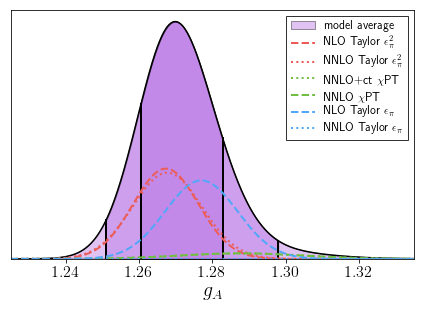

In [14]:
if switches['plot']['model_avg_histogram']:
    Plot = xlib.plot_chiral_fit()
    Plot.plot_histogram(switches,plot_params)

In [15]:
if switches['plot']['model_avg_chiral'] and switches['plot']['chiral']:
    Plot = xlib.plot_chiral_fit()
    Plot.model_avg_chiral(switches,phys_params,error['weights'],r_chiral)

In [16]:
if switches['plot']['model_avg_cont'] and switches['plot']['continuum']:
    Plot = xlib.plot_chiral_fit()
    Plot.model_avg_cont(switches,error['weights'],r_cont)

In [17]:
if switches['plot']['model_avg_fv'] and switches['plot']['FV']:
    Plot = xlib.plot_chiral_fit()
    Plot.model_avg_fv(switches,error['weights'],r_fv)

<center>
    <span style="color: black; font-family: Helvetica; font-size: 2em">
        These calculations are made possible by
    </span>
</center>

| | |
|:---:|:---:|
| [<img src='./data/incite_logo.png' width='200'/>](http://www.doeleadershipcomputing.org/)  | [<img src='./data/olcf_logo.png' width='260'/>](https://www.olcf.ornl.gov/) |
| [<img src='./data/llnl_logo.png' width='640' />](https://hpc.llnl.gov/) | [<img src='./data/scidac_logo.png' width='350' />](http://www.scidac.gov/) |